# Strategy 5 - Simple RNN for Price Prediction

Dans ce notebook, nous allons implémenter et tester une stratégie basée sur un RNN simple pour la prédiction des prix. Nous utiliserons la même structure de validation croisée que dans la stratégie 4.

In [1]:
import sys
import os

# Get the parent directory of the "notebook" folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to the Python path
sys.path.append(project_root)

In [27]:
from strategies.simple_rnn import SimpleRNNStrategy
from utils.backtest import Backtest
from utils.data_handler import DataHandler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
data_handler = DataHandler(ticker='AAPL', start_date='2010-01-01', end_date='2022-01-01')
data = data_handler.fetch_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
# Création et entraînement de la stratégie RNN
rnn_strategy = SimpleRNNStrategy(lookback=30, n_splits=5, epochs=30)
signals = rnn_strategy.generate_signals(data)

# Affichage des scores de validation croisée
print("Cross-validation MSE scores:")
for i, score in enumerate(rnn_strategy.cv_scores, 1):
    print(f"Fold {i}: {score:.6f}")
print(f"\nMean MSE: {np.mean(rnn_strategy.cv_scores):.6f}")
print(f"Std MSE: {np.std(rnn_strategy.cv_scores):.6f}")

C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores:
Fold 1: 0.000011
Fold 2: 0.000020
Fold 3: 0.000019
Fold 4: 0.000038
Fold 5: 0.000751

Mean MSE: 0.000168
Std MSE: 0.000292


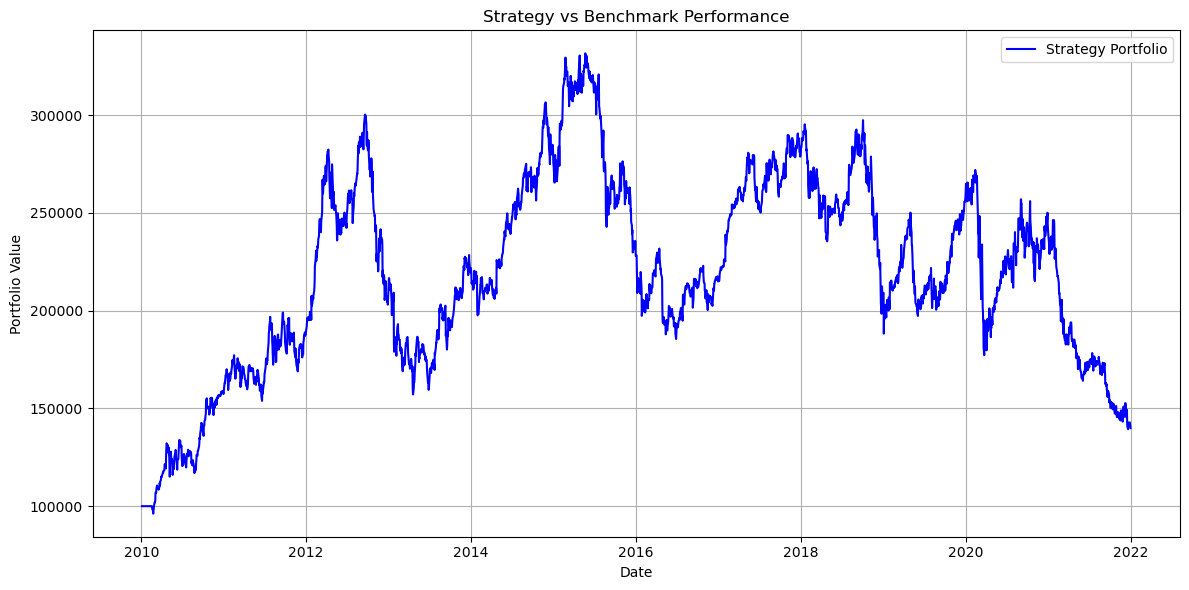

Final Value: 139933.3680
Return: 0.3993
Sharpe Ratio: 0.2391
Max Drawdown: -0.5796


In [6]:
# Backtest de la stratégie
backtest = Backtest(data, rnn_strategy)
results = backtest.run()

# Affichage des résultats
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

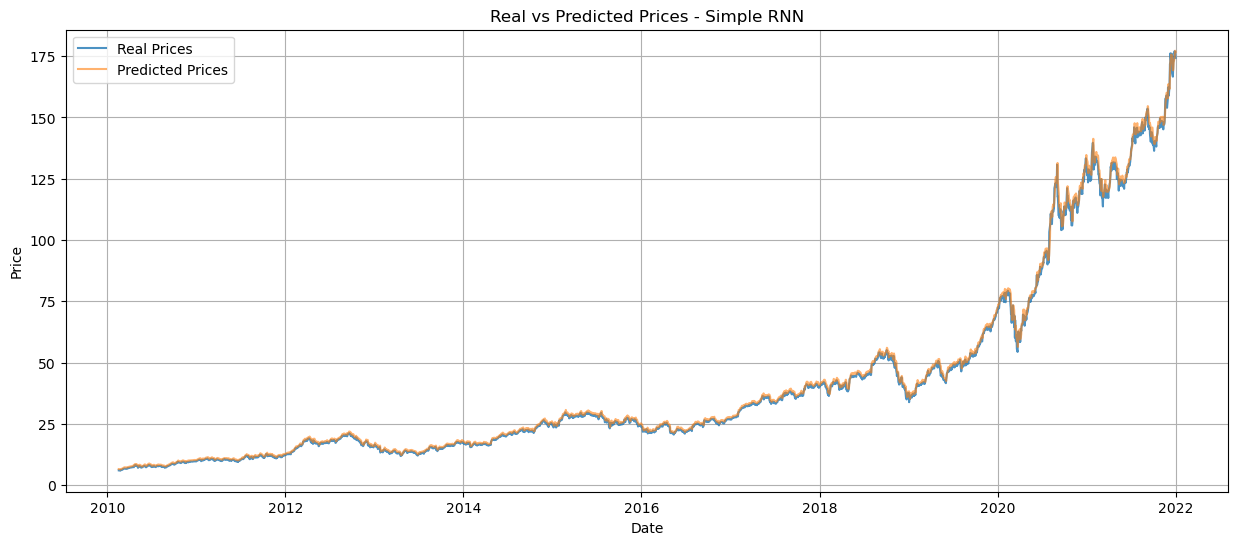

Mean Squared Error: 2.05
R² Score: 0.9986


In [7]:
# Obtenir les prédictions et les prix réels
X, y = rnn_strategy.prepare_data(data)
predictions = rnn_strategy.generate_prediction(X)

# Inverse transform des données scaled
predictions = rnn_strategy.scaler_X.inverse_transform(predictions)
y_actual = rnn_strategy.scaler_X.inverse_transform(y)

# Création d'un DataFrame pour la visualisation
prediction_index = data.index[rnn_strategy.lookback:]
df_comparison = pd.DataFrame({
    'Actual': y_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=prediction_index)

# Visualisation
plt.figure(figsize=(15, 6))
plt.plot(df_comparison.index, df_comparison['Actual'], label='Real Prices', alpha=0.8)
plt.plot(df_comparison.index, df_comparison['Predicted'], label='Predicted Prices', alpha=0.6)
plt.title('Real vs Predicted Prices - Simple RNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des métriques
mse = mean_squared_error(df_comparison['Actual'], df_comparison['Predicted'])
r2 = r2_score(df_comparison['Actual'], df_comparison['Predicted'])

print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.4f}')

## Analyse des résultats

Comparaison avec la stratégie basée sur les indicateurs techniques :
1. Performance globale
2. Stabilité des prédictions (std des CV scores)
3. Ratio de Sharpe et drawdown maximum

Points clés à noter :
- Le RNN simple utilise uniquement les prix de clôture passés
- La fenêtre glissante de 30 jours capture les dépendances temporelles
- Les signaux sont générés en comparant les prédictions aux prix actuels

## Backtesting sur 100 Stocks

In [35]:
in_sample_end = '2015-12-11'
out_sample_start = '2015-12-12'
out_sample_end = '2019-12-25'

tickers = [
    "AAPL", "ABT", "ADI", "ADM", "ADP", "ADSK", "AEE", "AEP", "AJG", "AKAM",
    "ALB", "AMAT", "AMD", "AME", "AMGN", "AMT", "AMZN", "AON", "AOS", "APA",
    "APD", "APH", "ARE", "AVB", "AVY", "AXP", "AZO", "BA", "BAC", "BAX",
    "BBY", "BDX", "BEN", "BIIB", "BK", "BLK", "BMY", "BSX", "BXP", "C",
    "CAG", "CAH", "CAT", "CB", "CCI", "CDNS", "CHD", "CHRW", "CINF", "CL",
    "CLX", "CMI", "CNP", "COO", "COP", "COST", "CPB", "CPRT", "CSCO", "CTAS",
    "CTSH", "D", "DE", "DGX", "DHI", "DIS", "DLTR", "DOV", "DRI", "DTE",
    "DVA", "EA", "EBAY", "ECL", "ED", "EFX", "EIX", "EL", "EMN", "EMR",
    "EOG", "EQR", "ES", "ESS", "F", "FAST", "FCX", "FDX", "FE", "FFIV",
    "FITB", "FRT", "GD", "GE", "GILD", "GIS", "GPC", "GWW", "HAL", "HAS"
] 

initial_cash = 100000
performance_summary = []
portfolio_series_list = []

In [37]:
for ticker in tickers:
    try:
        # Fetch data
        full_data_handler = DataHandler(ticker=ticker, start_date='2010-01-01', end_date=out_sample_end)
        full_data = full_data_handler.fetch_data()

        # Split data
        in_sample_data = full_data[full_data.index <= in_sample_end]
        out_sample_data = full_data[(full_data.index >= out_sample_start) & (full_data.index <= out_sample_end)]

        if len(in_sample_data) < 100 or len(out_sample_data) < 100:
            print(f"Skipping {ticker} due to insufficient data.")
            continue

        # Train RNN strategy on in-sample
        rnn_strategy = SimpleRNNStrategy(lookback=30, n_splits=5, epochs=30)
        rnn_strategy.fit(in_sample_data)

        # Backtest on out-of-sample
        backtest = Backtest(out_sample_data, rnn_strategy, initial_cash=initial_cash, plot_results=False)
        metrics = backtest.run()
        portfolio_series = backtest.get_portfolio_value_series()

        # Append results
        performance_summary.append({
            'Ticker': ticker,
            **metrics
        })
        portfolio_series_list.append(portfolio_series.rename(ticker))

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.997828464503982' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential

In [49]:
# Create DataFrame
perf_df = pd.DataFrame(performance_summary)

# Summary statistics
print("\n=== Summary Statistics ===")
print(perf_df.describe().round(4))

# Mean values
mean_metrics = perf_df[['Return', 'Sharpe Ratio', 'Final Value', 'Max Drawdown']].mean()
print("\n=== Mean Metrics ===")
print(mean_metrics.round(4))


=== Summary Statistics ===
       Final Value    Return  Sharpe Ratio  Max Drawdown
count     100.0000  100.0000      100.0000      100.0000
mean    11190.5873   -0.8881       -3.8413       -0.9188
std     29984.2394    0.2998        1.2907        0.0796
min       900.6372   -0.9910       -6.9855       -0.9938
25%      4357.8455   -0.9564       -4.7634       -0.9579
50%      6271.4149   -0.9373       -3.8224       -0.9381
75%      9257.2909   -0.9074       -3.0837       -0.9134
max    291665.3031    1.9167        0.7263       -0.4036

=== Mean Metrics ===
Return             -0.8881
Sharpe Ratio       -3.8413
Final Value     11190.5873
Max Drawdown       -0.9188
dtype: float64


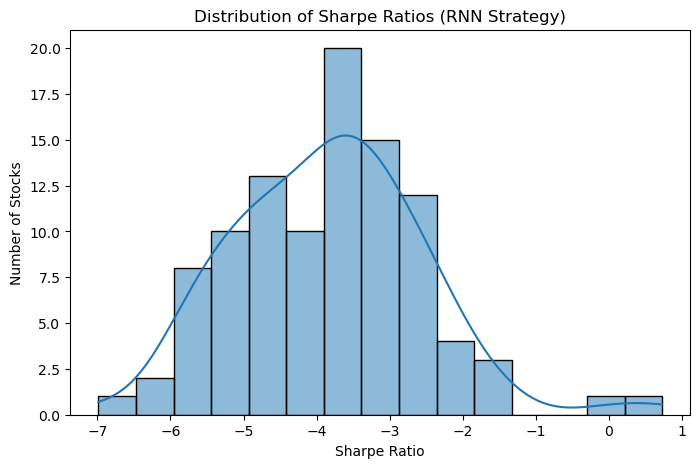

In [51]:
plt.figure(figsize=(8, 5))
sns.histplot(perf_df['Sharpe Ratio'], kde=True, bins=15)
plt.title('Distribution of Sharpe Ratios (RNN Strategy)')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Number of Stocks')
plt.show()


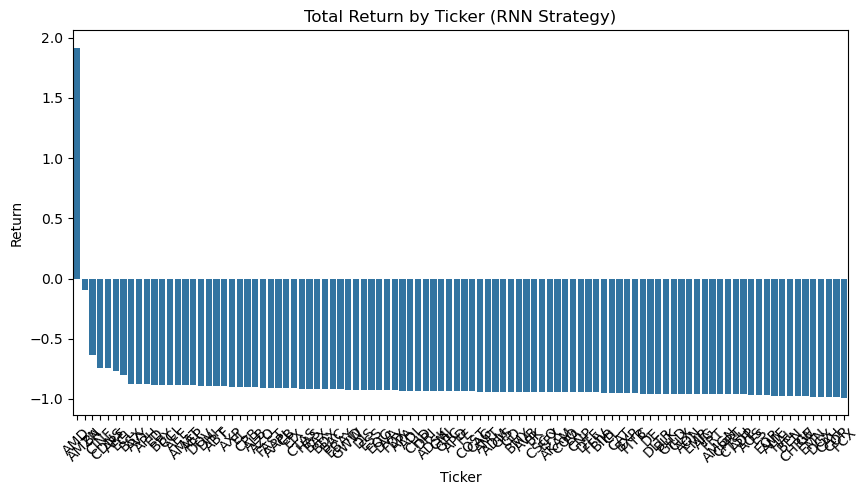

In [53]:
plt.figure(figsize=(10, 5))
sorted_df = perf_df.sort_values(by='Return', ascending=False)
sns.barplot(x='Ticker', y='Return', data=sorted_df)
plt.title('Total Return by Ticker (RNN Strategy)')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.show()


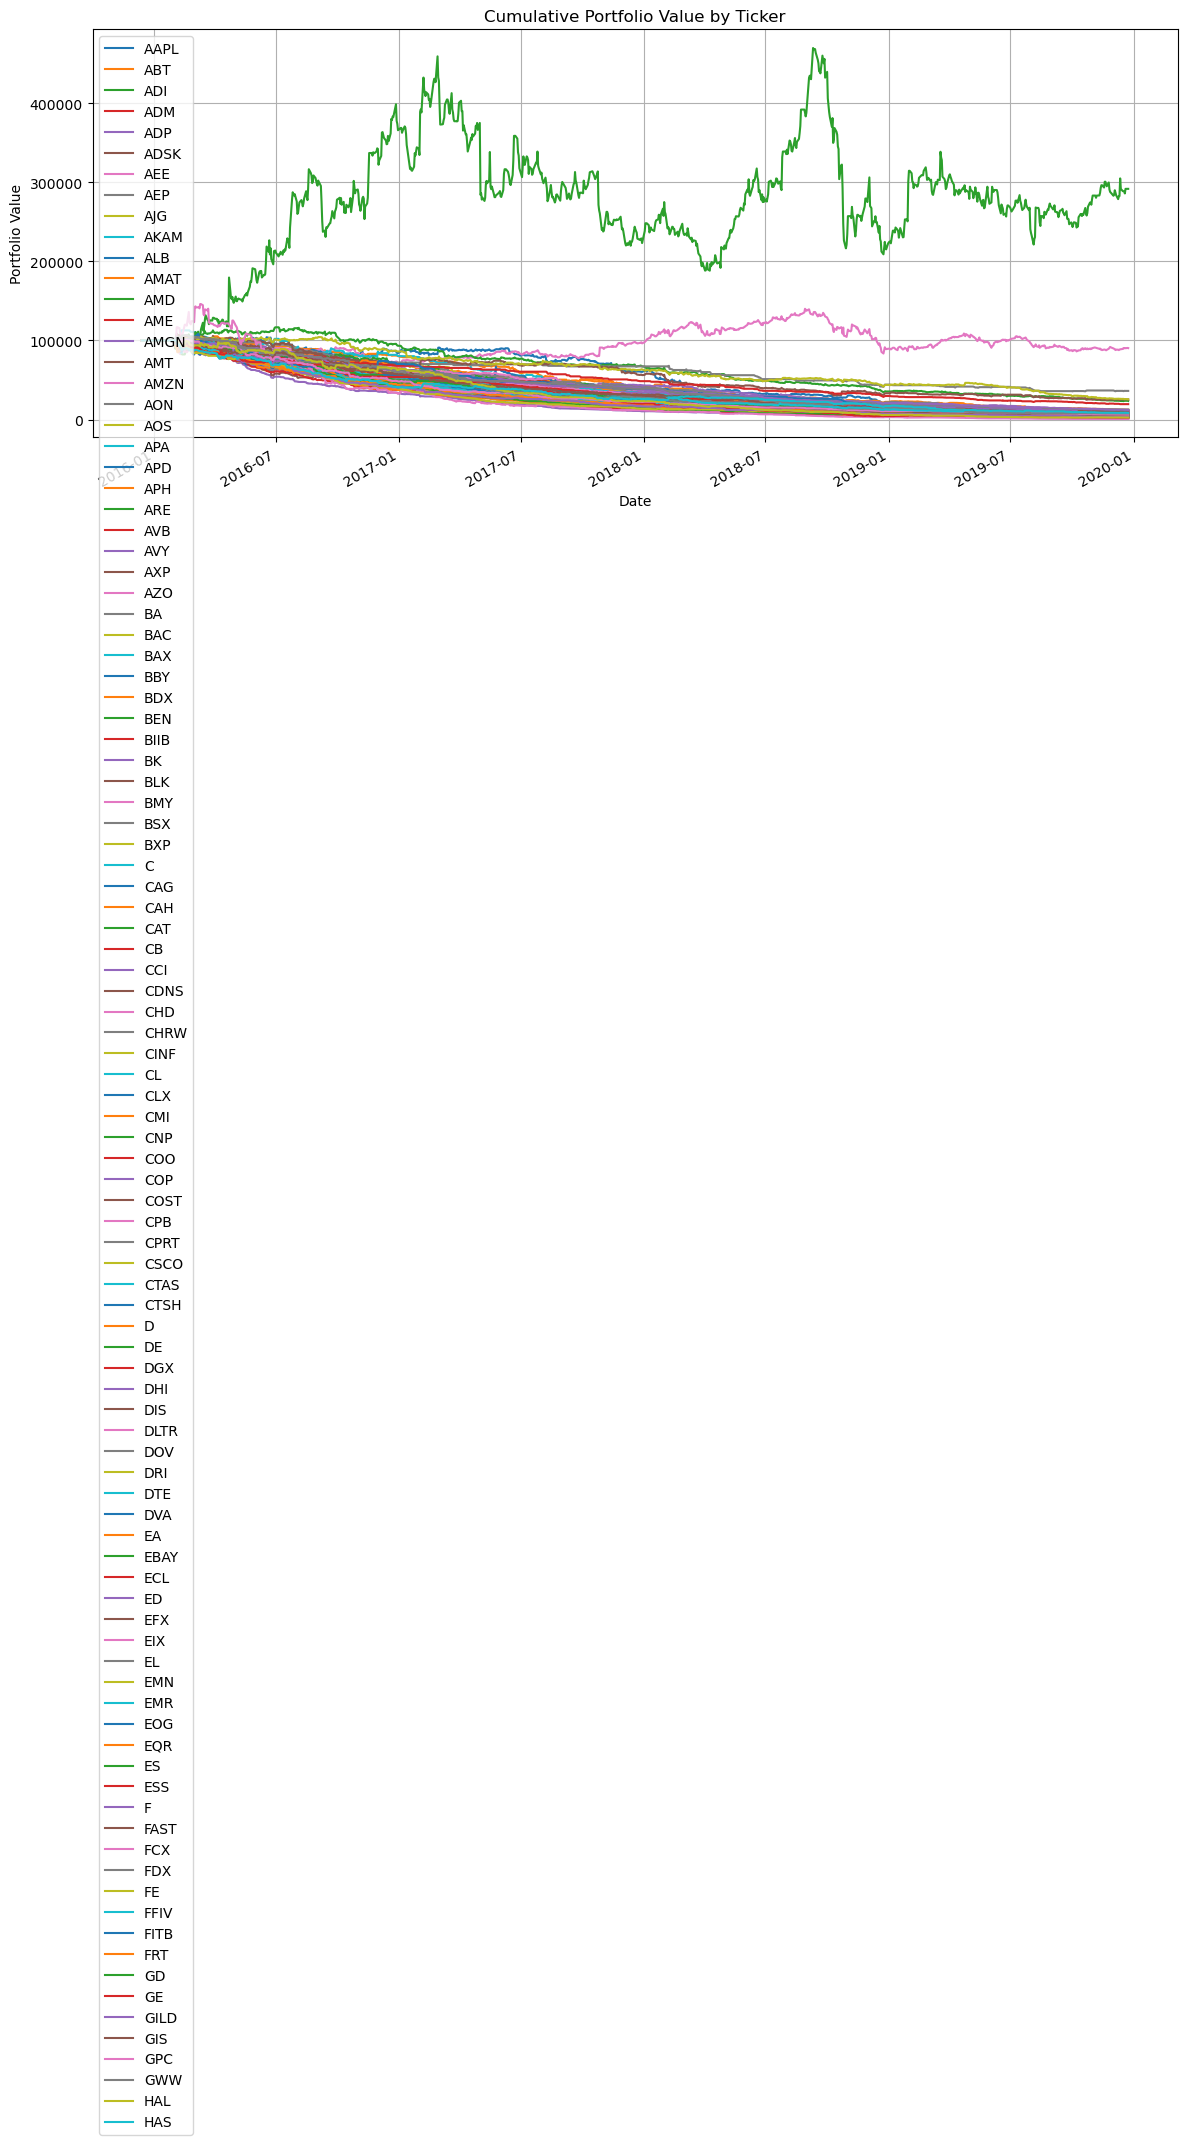

In [55]:
cumulative_df = pd.concat(portfolio_series_list, axis=1)
cumulative_df.plot(figsize=(14, 6), title='Cumulative Portfolio Value by Ticker')
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


In [42]:
perf_df.to_csv('rnn_backtest_results.csv', index=False)
cumulative_df.to_csv('rnn_portfolio_timeseries.csv')
